In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/text-documents/PageSegData/PageImg/208.JPG
/kaggle/input/text-documents/PageSegData/PageImg/45.JPG
/kaggle/input/text-documents/PageSegData/PageImg/56.JPG
/kaggle/input/text-documents/PageSegData/PageImg/89.JPG
/kaggle/input/text-documents/PageSegData/PageImg/20.JPG
/kaggle/input/text-documents/PageSegData/PageImg/275.JPG
/kaggle/input/text-documents/PageSegData/PageImg/212.JPG
/kaggle/input/text-documents/PageSegData/PageImg/239.JPG
/kaggle/input/text-documents/PageSegData/PageImg/58.JPG
/kaggle/input/text-documents/PageSegData/PageImg/150.JPG
/kaggle/input/text-documents/PageSegData/PageImg/6.JPG
/kaggle/input/text-documents/PageSegData/PageImg/109.JPG
/kaggle/input/text-documents/PageSegData/PageImg/149.JPG
/kaggle/input/text-documents/PageSegData/PageImg/187.JPG
/kaggle/input/text-documents/PageSegData/PageImg/76.JPG
/kaggle/input/text-documents/PageSegData/PageImg/71.JPG
/kaggle/input/text-documents/PageSegData/PageImg/272.JPG
/kaggle/input/text-documents/PageSegData

In [2]:
image_list=os.listdir('/kaggle/input/text-documents/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

In [3]:
def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()

In [4]:
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]

    
    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels

In [5]:
def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

In [6]:
def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/kaggle/input/text-documents/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      img=img/255

      seg=cv2.imread(f'/kaggle/input/text-documents/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

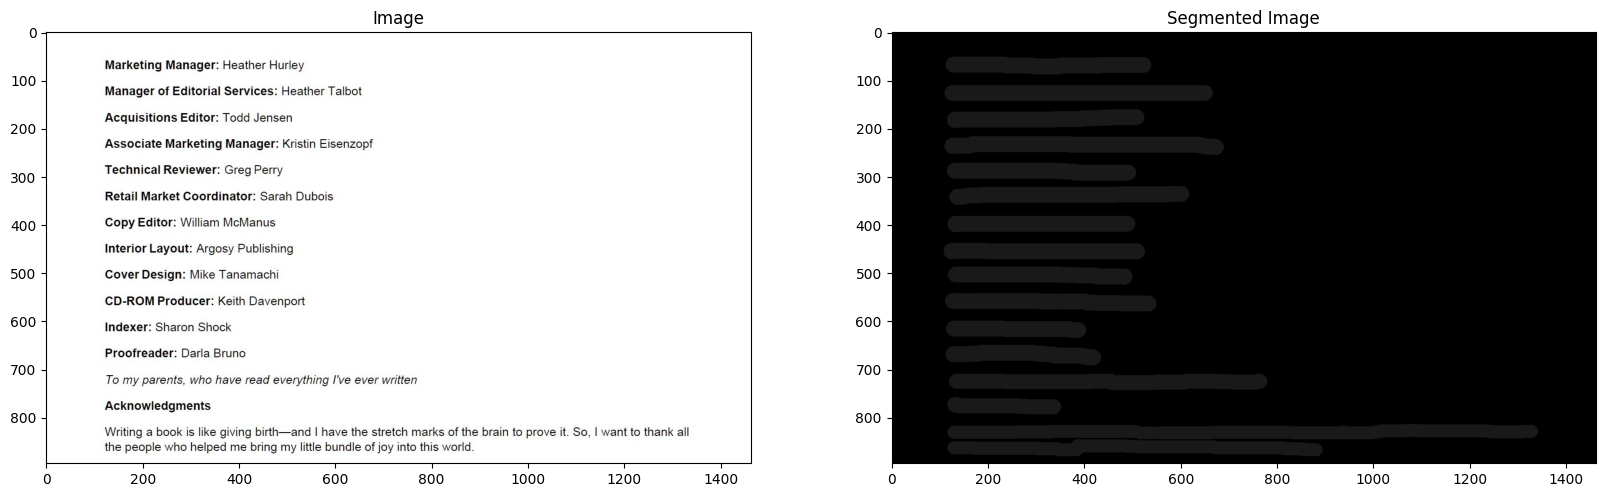

In [7]:
img=cv2.imread('/kaggle/input/text-documents/PageSegData/PageImg/'+image_list[30]+'.JPG',1)
seg=cv2.imread('/kaggle/input/text-documents/PageSegData/PageSeg/'+image_list[30]+'_mask.png',1)

visualize(img,seg)

In [8]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model

model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [9]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

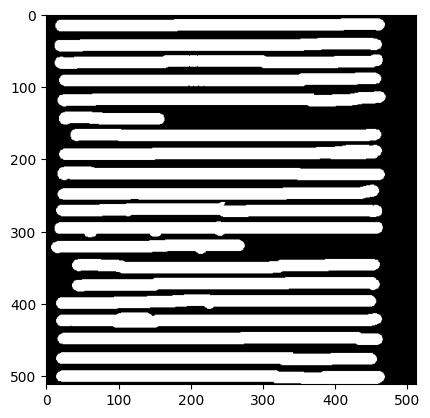

In [10]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray');

In [11]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('/kaggle/working/weights{epoch:08d}.h5', save_weights_only=True, save_best_only= True)

In [13]:
history = model.fit(batch_generator(file_train,2,2),epochs=5,steps_per_epoch=1000,validation_data=batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

Epoch 1/5
1000/1000 [==============================] - 733s 733ms/step - loss: 0.1504 - accuracy: 0.9348 - val_loss: 0.1514 - val_accuracy: 0.9330
Epoch 2/5
1000/1000 [==============================] - 741s 741ms/step - loss: 0.1340 - accuracy: 0.9415 - val_loss: 0.1529 - val_accuracy: 0.9339
Epoch 3/5
1000/1000 [==============================] - 726s 726ms/step - loss: 0.1400 - accuracy: 0.9405 - val_loss: 0.1485 - val_accuracy: 0.9370
Epoch 4/5
1000/1000 [==============================] - 737s 737ms/step - loss: 0.1255 - accuracy: 0.9444 - val_loss: 0.1412 - val_accuracy: 0.9395
Epoch 5/5
1000/1000 [==============================] - 738s 738ms/step - loss: 0.1181 - accuracy: 0.9475 - val_loss: 0.1670 - val_accuracy: 0.9357


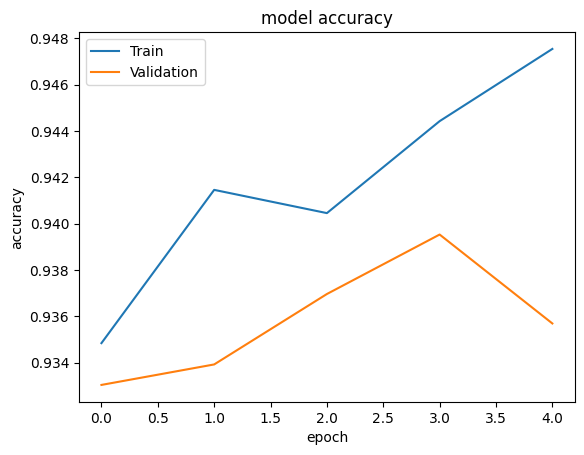

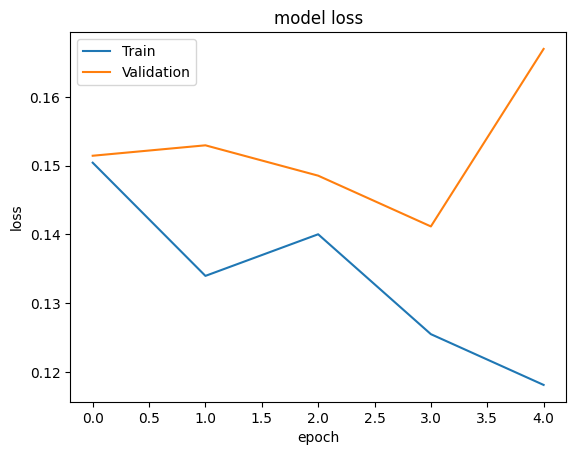

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import seaborn as sns
img=cv2.imread(f'/kaggle/input/testing/test.jpg',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)

1/1 [==============================] - 6s 6s/step


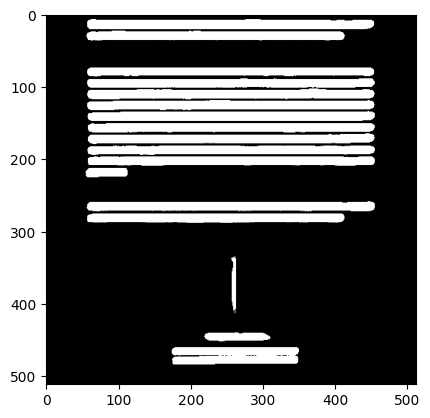

In [18]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

True

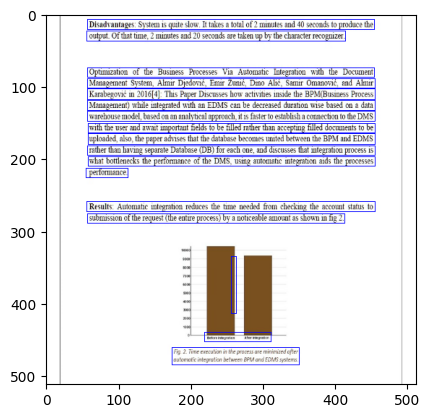

In [20]:
plt.imsave('/kaggle/working/page_test_img_mask.JPG',pred)
     

coordinates=[]

img = cv2.imread('/kaggle/working/page_test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/kaggle/input/testing/test.jpg')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), (0,0,255), 1)
    coordinates.append([x,y,(x+w),(y+h)])

# cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
plt.imshow(ori_img);
cv2.imwrite("/kaggle/working/output1.png",ori_img)
